In [20]:
from pandas.io.formats.printing import PrettyDict
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X = X.values
y= y.astype(int).values

print(X.shape)
print(y.shape)

# Now we should normalize the pixel values
X = ((X / 255.) - .5) * 2

(70000, 784)
(70000,)


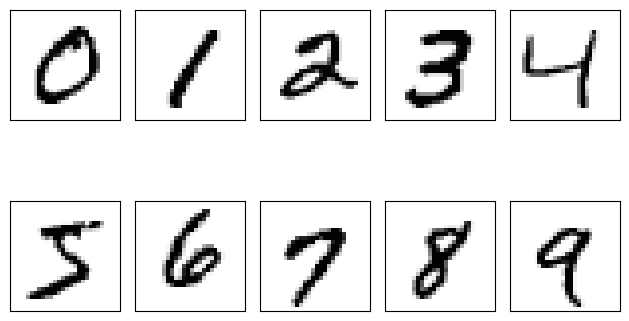

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28,28)
    ax[i].imshow(img,cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

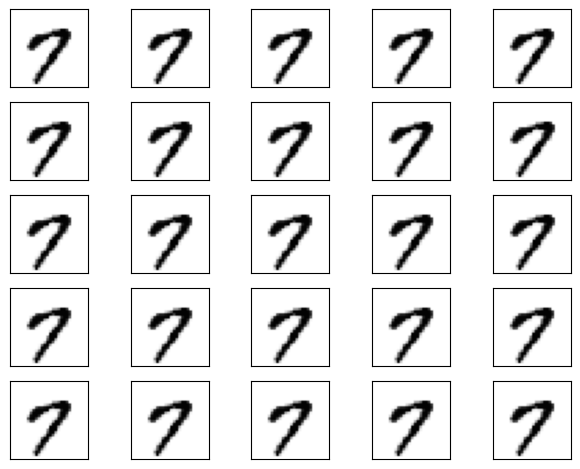

In [22]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()
for i in range(25):
    img = X[y == 7][0].reshape(28,28)
    ax[i].imshow(img,cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [23]:
# Train test split
X_temp, X_test, y_temp, y_test = train_test_split(X,y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

# import the neural network we just made
from neuralnet import NeuralNetMLP, int_to_onehot

model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

In [24]:

# Training loop
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X,y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_indx in range(0, indices.shape[0] - minibatch_size + 1,
        minibatch_size):
            batch_idx = indices[start_indx:start_indx + minibatch_size]
            yield X[batch_idx], y[batch_idx]


# Lets test if the mini batches are getting generated!
for i in range(num_epochs):
   # iterate of minibatches
   minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

   for X_train_mini, y_train_mini in minibatch_gen:
       break
   break

print(X_train_mini.shape)
print(y_train_mini)

(100, 784)
[6 2 6 8 0 4 1 7 5 1 9 1 7 9 9 5 5 8 6 5 9 6 8 6 3 2 5 1 0 4 6 4 7 2 3 6 9
 5 9 5 4 6 9 7 6 3 7 2 9 2 1 5 7 1 5 9 8 1 7 9 0 5 8 4 9 4 5 8 3 2 1 1 3 8
 8 0 5 5 2 8 7 6 7 9 2 9 6 8 0 5 6 9 3 5 0 8 2 2 2 3]


In [25]:
def mse_loss(targets, probas, num_labels=10):
    one_hot_targets = int_to_onehot(
        targets, num_labels=num_labels
    )
    return np.mean((one_hot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


# Lets test the preceiding functions
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f"Inital validation MSE: {mse:.1f}")

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f"Inital Accuracy: {acc * 100:.1f}")


Inital validation MSE: 0.3
Inital Accuracy: 9.4


In [26]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0,0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    num_minibatches = 0
    for features, targets in minibatch_gen:
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(
            targets, num_labels=num_labels
        )
        loss = np.mean((probas - onehot_targets)**2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
        num_minibatches += 1

    mse = mse/num_minibatches
    acc = correct_pred/num_examples
    return mse,acc

mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f"Initial valid MSE: {mse:.1f}")
print(f"Initial valid accuracy: {acc*100:.1f}%")

Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


In [27]:
# Training
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):
        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            ### computing outputs ###
            a_h, a_out = model.forward(X_train_mini)

            ### Compute Gradients ###
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            ### Update weights ###
            model.weight_hidden -= learning_rate * d_loss__d_w_h
            model.bias_hidden -= learning_rate * d_loss__d_b_h
            model.weight_output -= learning_rate * d_loss__d_w_out
            model.bias_output -= learning_rate * d_loss__d_b_out

        ### Epoch Logs ###
        train_mse, train_acc = compute_mse_and_acc(
            model, X_train, y_train
        )
        valid_mse, valid_acc = compute_mse_and_acc(
            model, X_valid, y_valid
        )
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)

        print(f"Epoch: {e+1:03d}/{num_epochs:03d}s "
            f"| Train MSE: {train_mse:.2f} "
            f"| Train Acc: {train_acc:0.2f}% "
            f"| Valid Acc: {valid_acc:0.2f}% "
        )

    return epoch_loss, epoch_train_acc, epoch_valid_acc


# Actually training

np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid, num_epochs=50, learning_rate=0.1
)


Epoch: 001/050s | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98% 
Epoch: 002/050s | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04% 
Epoch: 003/050s | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60% 
Epoch: 004/050s | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28% 
Epoch: 005/050s | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04% 
Epoch: 006/050s | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54% 
Epoch: 007/050s | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82% 
Epoch: 008/050s | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26% 
Epoch: 009/050s | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50% 
Epoch: 010/050s | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84% 
Epoch: 011/050s | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08% 
Epoch: 012/050s | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24% 
Epoch: 013/050s | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30% 
Epoch: 014/050s | Train M

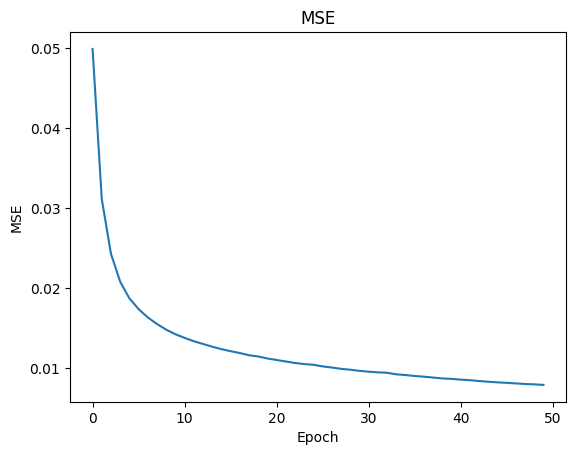

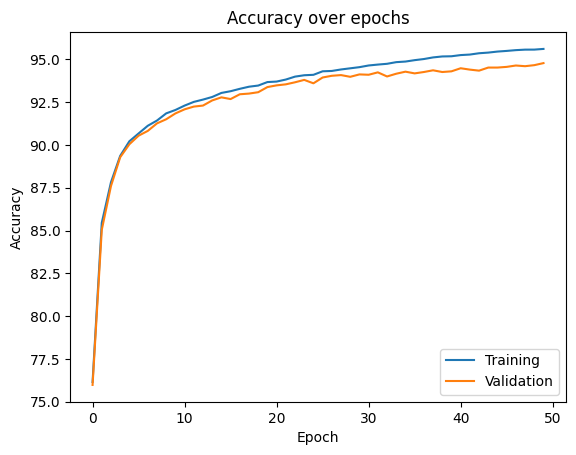

In [28]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.title("MSE")
plt.show()


plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label="Training")
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label="Validation")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.title("Accuracy over epochs")
plt.show()

Validation accuracy: 94.8%


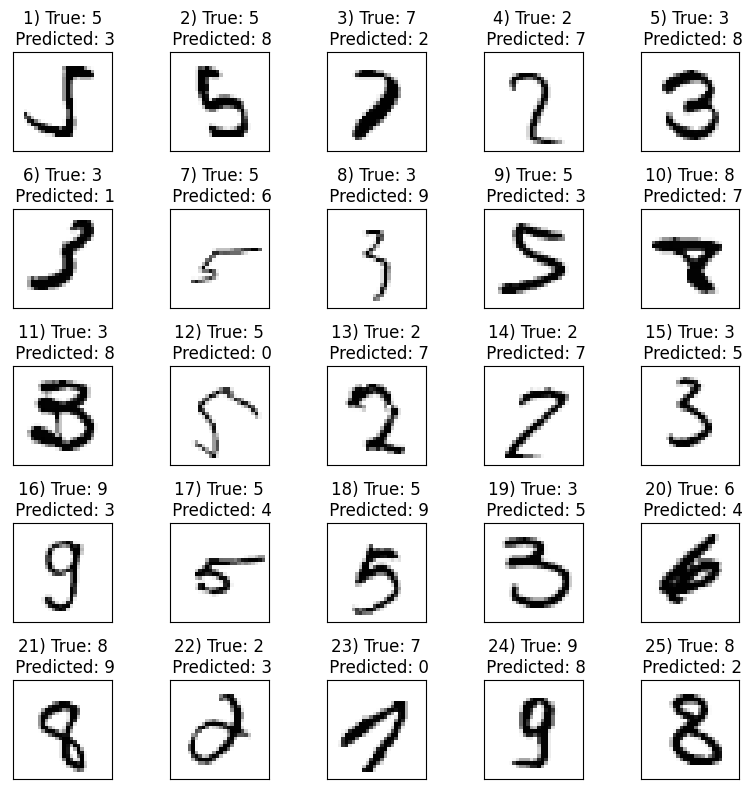

In [29]:
valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f"Validation accuracy: {valid_acc*100:.1f}%")

X_valid_subset = X_valid[:1000, :]
y_valid_subset = y_valid[:1000]

_, probas = model.forward(X_valid_subset)
test_pred = np.argmax(probas,axis=1)

misclassified_images = X_valid_subset[y_valid_subset != test_pred][:25]
misclassified_labels = test_pred[y_valid_subset != test_pred][:25]

corrrect_labels = y_valid_subset[y_valid_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8,8))

ax = ax.flatten()

for i in range(25):
    img = misclassified_images[i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {corrrect_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}') 
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()